<a href="https://colab.research.google.com/github/fatihdzaki01/Projek_PDS_RegresiLinier/blob/njm/projek_pds.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## IMPORT LIBRARY AND LOAD DATASET

In [2]:
#Import Library yang Dibutuhkan

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import geopandas as gpd
import folium
from folium import Choropleth
import statsmodels.api as sm
from sklearn.metrics import mean_squared_error
from statsmodels.stats.outliers_influence import variance_inflation_factor
from statsmodels.stats.diagnostic import het_breuschpagan
from scipy.stats import shapiro
import statsmodels.api as sm

# tampilkan semua kolom
pd.set_option('display.max_columns', None)

In [ ]:
# --- Import Data ---
df = pd.read_csv("air_quality.csv")

# lihat 5 baris pertama
df.head()


/tmp/ipython-input-2544857966.py:2: DtypeWarning: Columns (6,7,8,9,10,11,12,13,14,15,16,18,19,20,21) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("air_quality.csv")


,date,sitename,county,aqi,pollutant,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,unit,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
0,2024-08-31 23:00,Hukou,Hsinchu County,62.0,PM2.5,Moderate,0.9,0.17,35.0,40.2,18.0,17.0,2.3,2.6,0.3,2.3,225,NaN,0.2,20.1,26.0,1.0,121.038869,24.900097,22.0
1,2024-08-31 23:00,Zhongming,Taichung City,50.0,NaN,Good,1.6,0.32,27.9,35.1,27.0,14.0,7.6,9.3,1.6,1.1,184,NaN,0.2,15.3,23.0,1.0,120.641092,24.151958,31.0
2,2024-08-31 23:00,Zhudong,Hsinchu County,45.0,NaN,Good,0.4,0.17,25.1,40.6,21.0,13.0,2.9,4.1,1.1,0.4,210,NaN,0.2,13.8,24.0,0.0,121.088955,24.740914,23.0
3,2024-08-31 23:00,Hsinchu,Hsinchu City,42.0,NaN,Good,0.8,0.2,30.0,35.9,19.0,10.0,4.0,4.8,0.7,1.9,239,NaN,0.2,13.0,26.0,1.0,120.972368,24.805636,24.0
4,2024-08-31 23:00,Toufen,Miaoli County,50.0,NaN,Good,1.0,0.16,33.5,35.9,18.0,14.0,1.8,3.1,1.2,1.8,259,NaN,0.1,15.3,28.0,1.0,120.898693,24.696907,25.0


In [ ]:
#lakukan pengarsipan
df_raw = df.copy()

## DATA PREPROCESSING

### Eksplorasi awal

In [ ]:
#Eksplorasi Awal
df.info()
df.describe()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5882208 entries, 0 to 5882207
Data columns (total 25 columns):
 #   Column     Dtype  
---  ------     -----  
 0   date       object 
 1   sitename   object 
 2   county     object 
 3   aqi        float64
 4   pollutant  object 
 5   status     object 
 6   so2        object 
 7   co         object 
 8   o3         object 
 9   o3_8hr     object 
 10  pm10       object 
 11  pm2.5      object 
 12  no2        object 
 13  nox        object 
 14  no         object 
 15  windspeed  object 
 16  winddirec  object 
 17  unit       float64
 18  co_8hr     object 
 19  pm2.5_avg  object 
 20  pm10_avg   object 
 21  so2_avg    object 
 22  longitude  float64
 23  latitude   float64
 24  siteid     float64
dtypes: float64(5), object(20)
memory usage: 1.1+ GB


,aqi,unit,longitude,latitude,siteid
count,5.839188e+06,0.0,4.948588e+06,4.948588e+06,4.102739e+06
mean,5.419277e+01,NaN,1.208235e+02,2.404500e+01,5.608608e+01
std,2.985864e+01,NaN,9.644120e-01,1.002014e+00,6.233482e+01
min,-1.000000e+00,NaN,0.000000e+00,0.000000e+00,0.000000e+00
25%,3.200000e+01,NaN,1.203455e+02,2.304820e+01,2.100000e+01
50%,4.600000e+01,NaN,1.206853e+02,2.415196e+01,4.200000e+01
75%,7.000000e+01,NaN,1.214492e+02,2.501297e+01,6.500000e+01
max,5.000000e+02,NaN,1.218157e+02,2.625800e+01,3.140000e+02


### Penyesuaian Tipe Data

In [ ]:
# lihat tipe data yang sekarang
df.dtypes

,0
date,object
sitename,object
county,object
aqi,float64
pollutant,object
status,object
so2,object
co,object
o3,object
o3_8hr,object


In [ ]:
# ubah beberapa kolom menjadi numerik
cols_num = ['aqi', 'so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2',
             'nox', 'no', 'windspeed', 'winddirec', 'co_8hr',
             'pm2.5_avg', 'pm10_avg', 'so2_avg']

for c in cols_num:
    if c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')

In [ ]:
# ubah tipedata kolom 'date' menjadi date
df['date'] = pd.to_datetime(df['date'], format='mixed', errors='coerce')

In [ ]:
# cek kembali tipedata , untuk memastikan sudah sesuai
df.dtypes

,0
date,datetime64[ns]
sitename,object
county,object
aqi,float64
pollutant,object
status,object
so2,float64
co,float64
o3,float64
o3_8hr,float64


### Cek Missing Value

In [ ]:
# cek missing value
print(df.isnull().sum())

date               0
sitename           0
county             0
aqi            43020
pollutant    3235012
status        142718
so2           139791
co            154131
o3            207426
o3_8hr        153648
pm10          146653
pm2.5         202225
no2           166000
nox           169147
no            169478
windspeed     302683
winddirec     302921
unit         5882208
co_8hr        103553
pm2.5_avg      79964
pm10_avg       96170
so2_avg       629185
longitude     933620
latitude      933620
siteid       1779469
dtype: int64


lakukan penghapusan row dimana longitude, latitude dan siteid nya NULL, karena tidak bisa dilakukan visualisasi MAP

In [ ]:
# hapus row dengan kolom longitude, latitude dan siteid NULL, karena tidak bisa dibuat visualisasi map
id_cols = ['longitude', 'latitude', 'siteid']
for c in id_cols:
    if c in df.columns:
        df = df.dropna(subset=[c])

In [ ]:
# persentase missing value
(df.isnull().sum() / len(df)) * 100

,0
date,0.000000
sitename,0.000000
county,0.000000
aqi,0.300824
pollutant,59.065971
status,0.467973
so2,2.353898
co,2.230693
o3,3.042303
o3_8hr,2.051673


karena kolom 'pollutant' dan 'unit' memiliki persentase missing value cukup besar (> 50%) maka kolom tersebut kami hapus

In [ ]:
# hapus kolom pollutant dan unit
df.drop(columns=['unit', 'pollutant'], inplace = True)

untuk menentukan apakah missing value di isi menggunakan median atau mean, wajib melihat outlier dan distribusinya. jika berdistribusi normal, maka sebaiknya menggunakan mean, jika tidak berdistribusi normal dan punya banyak outlier maka menggunakan median

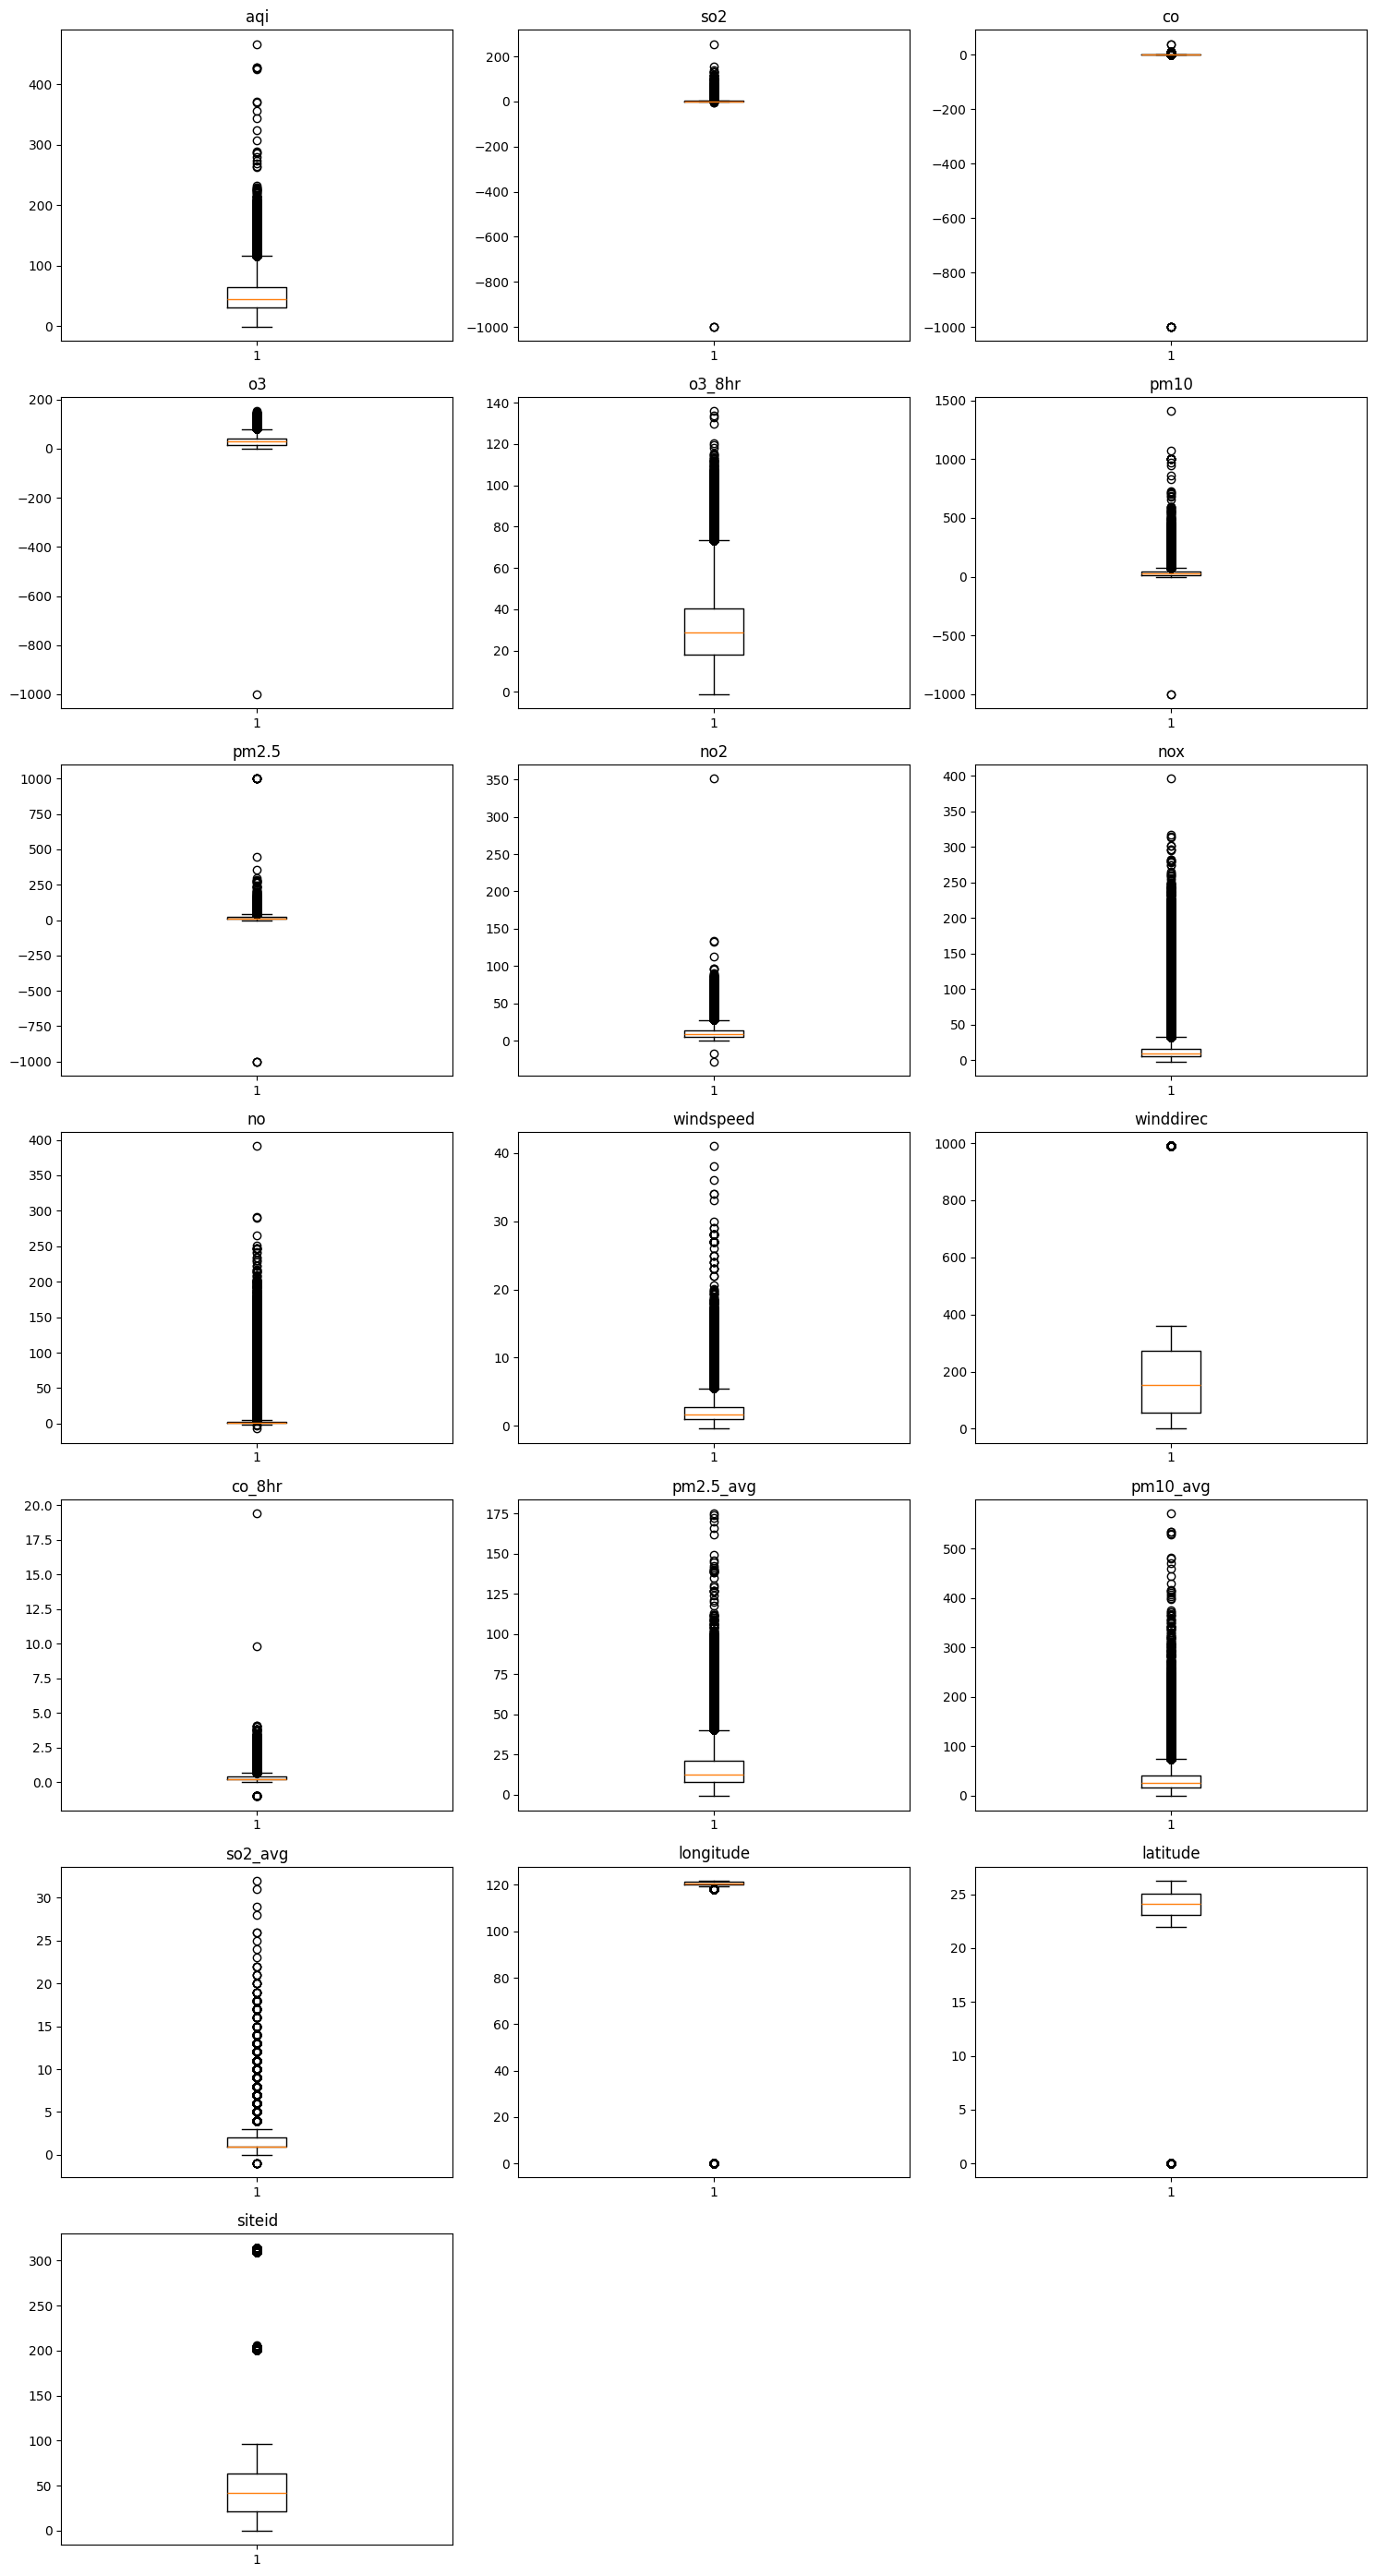

In [ ]:
# cek outlier
import matplotlib.pyplot as plt
import pandas as pd

# Pilih kolom numerik
numeric_cols = df.select_dtypes(include=['float64']).columns

n_cols = 3  # jumlah kolom di grid
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Buat figure
plt.figure(figsize=(n_cols * 5, n_rows * 4))

# Loop tiap kolom dan plot boxplot-nya
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.boxplot(df[col].dropna(), vert=True)
    plt.title(col)
    plt.tight_layout()

plt.show()


karena hampir semua kolom memilki nilai outlier, oleh karena itu pengisian missing value menggunakan nilai median

In [ ]:
# Isi missing value pada kolom numerik dgn median karena lebih tahan terhadap outlier dibanding mean
for c in cols_num:
    if c in df.columns:
        median_value = df[c].median()
        df[c] = df[c].fillna(median_value)

In [ ]:
# menangani kolom status
# cek nilai unique
df['status'].unique()

array(['Moderate', 'Good', nan, 'Unhealthy for Sensitive Groups',
       'Unhealthy', 'Very Unhealthy', 'Hazardous'], dtype=object)

In [ ]:
df.groupby('status')['aqi'].agg(['min', 'max']).reset_index()

,status,min,max
0,Good,0.0,84.0
1,Hazardous,307.0,467.0
2,Moderate,44.0,100.0
3,Unhealthy,44.0,200.0
4,Unhealthy for Sensitive Groups,44.0,150.0
5,Very Unhealthy,201.0,289.0


In [ ]:
# fungsi untuk menentukan status berdasarkan nilai AQI
def categorize_aqi(aqi):
    if pd.isna(aqi):
        return None
    elif 0 <= aqi <= 50:
        return 'Good'
    elif 51 <= aqi <= 100:
        return 'Moderate'
    elif 101 <= aqi <= 150:
        return 'Unhealthy for Sensitive Groups'
    elif 151 <= aqi <= 200:
        return 'Unhealthy'
    elif 201 <= aqi <= 300:
        return 'Very Unhealthy'
    elif aqi >= 301:
        return 'Hazardous'
    else:
        return 'Unknown'

In [ ]:
df['status'] = df.apply(
    lambda row: categorize_aqi(row['aqi']) if pd.isna(row['status']) else row['status'],
    axis=1
)

In [ ]:
# --- Cek hasil akhir ---
print("Missing values setelah pembersihan:\n", df.isnull().sum())

Missing values setelah pembersihan:
 date         0
sitename     0
county       0
aqi          0
status       0
so2          0
co           0
o3           0
o3_8hr       0
pm10         0
pm2.5        0
no2          0
nox          0
no           0
windspeed    0
winddirec    0
co_8hr       0
pm2.5_avg    0
pm10_avg     0
so2_avg      0
longitude    0
latitude     0
siteid       0
dtype: int64


In [ ]:
#lakukan pengarsipan untuk missing value
df_missingvalue = df.copy()

### Cek Duplikasi data

In [ ]:
#cek duplikat
df.duplicated().any()

np.True_

In [ ]:
# melihat duplikasi

dupes = df[df.duplicated(keep=False)]
dupes.sort_values(by=list(df.columns)).head(20)

,date,sitename,county,aqi,status,so2,co,o3,o3_8hr,pm10,pm2.5,no2,nox,no,windspeed,winddirec,co_8hr,pm2.5_avg,pm10_avg,so2_avg,longitude,latitude,siteid
3147787,2020-11-11 17:00:00,Zhudong,Hsinchu County,42.0,Good,1.4,0.05,44.5,45.0,24.0,10.0,3.5,4.4,0.9,8.3,32.0,0.1,8.0,25.0,1.0,121.088903,24.740644,23.0
3147824,2020-11-11 17:00:00,Zhudong,Hsinchu County,42.0,Good,1.4,0.05,44.5,45.0,24.0,10.0,3.5,4.4,0.9,8.3,32.0,0.1,8.0,25.0,1.0,121.088903,24.740644,23.0
3147667,2020-11-11 18:00:00,Zhudong,Hsinchu County,42.0,Good,1.2,0.05,44.4,45.0,24.0,8.0,3.3,3.9,0.6,8.0,28.0,0.1,9.0,25.0,1.0,121.088903,24.740644,23.0
3147729,2020-11-11 18:00:00,Zhudong,Hsinchu County,42.0,Good,1.2,0.05,44.4,45.0,24.0,8.0,3.3,3.9,0.6,8.0,28.0,0.1,9.0,25.0,1.0,121.088903,24.740644,23.0
3147587,2020-11-11 19:00:00,Zhudong,Hsinchu County,42.0,Good,1.4,0.05,45.0,45.0,25.0,6.0,3.0,3.2,0.3,8.5,31.0,0.1,8.0,25.0,1.0,121.088903,24.740644,23.0
3147634,2020-11-11 19:00:00,Zhudong,Hsinchu County,42.0,Good,1.4,0.05,45.0,45.0,25.0,6.0,3.0,3.2,0.3,8.5,31.0,0.1,8.0,25.0,1.0,121.088903,24.740644,23.0
3147503,2020-11-11 20:00:00,Zhudong,Hsinchu County,42.0,Good,1.5,0.05,44.5,45.0,22.0,10.0,2.6,3.1,0.5,6.8,32.0,0.1,8.0,24.0,1.0,121.088903,24.740644,23.0
3147551,2020-11-11 20:00:00,Zhudong,Hsinchu County,42.0,Good,1.5,0.05,44.5,45.0,22.0,10.0,2.6,3.1,0.5,6.8,32.0,0.1,8.0,24.0,1.0,121.088903,24.740644,23.0
3147439,2020-11-11 21:00:00,Zhudong,Hsinchu County,42.0,Good,1.5,0.05,44.3,45.0,19.0,9.0,2.5,3.0,0.5,5.8,36.0,0.1,8.0,23.0,1.0,121.088903,24.740644,23.0
3147460,2020-11-11 21:00:00,Zhudong,Hsinchu County,42.0,Good,1.5,0.05,44.3,45.0,19.0,9.0,2.5,3.0,0.5,5.8,36.0,0.1,8.0,23.0,1.0,121.088903,24.740644,23.0


In [ ]:
#hapus duplikat
df.drop_duplicates(inplace=True)

In [ ]:
df_duplikasi = df.copy()

### Cek Distribusi

cara paling mudah dan simple melihat distribusi ialah dengan menggunakan histogram.

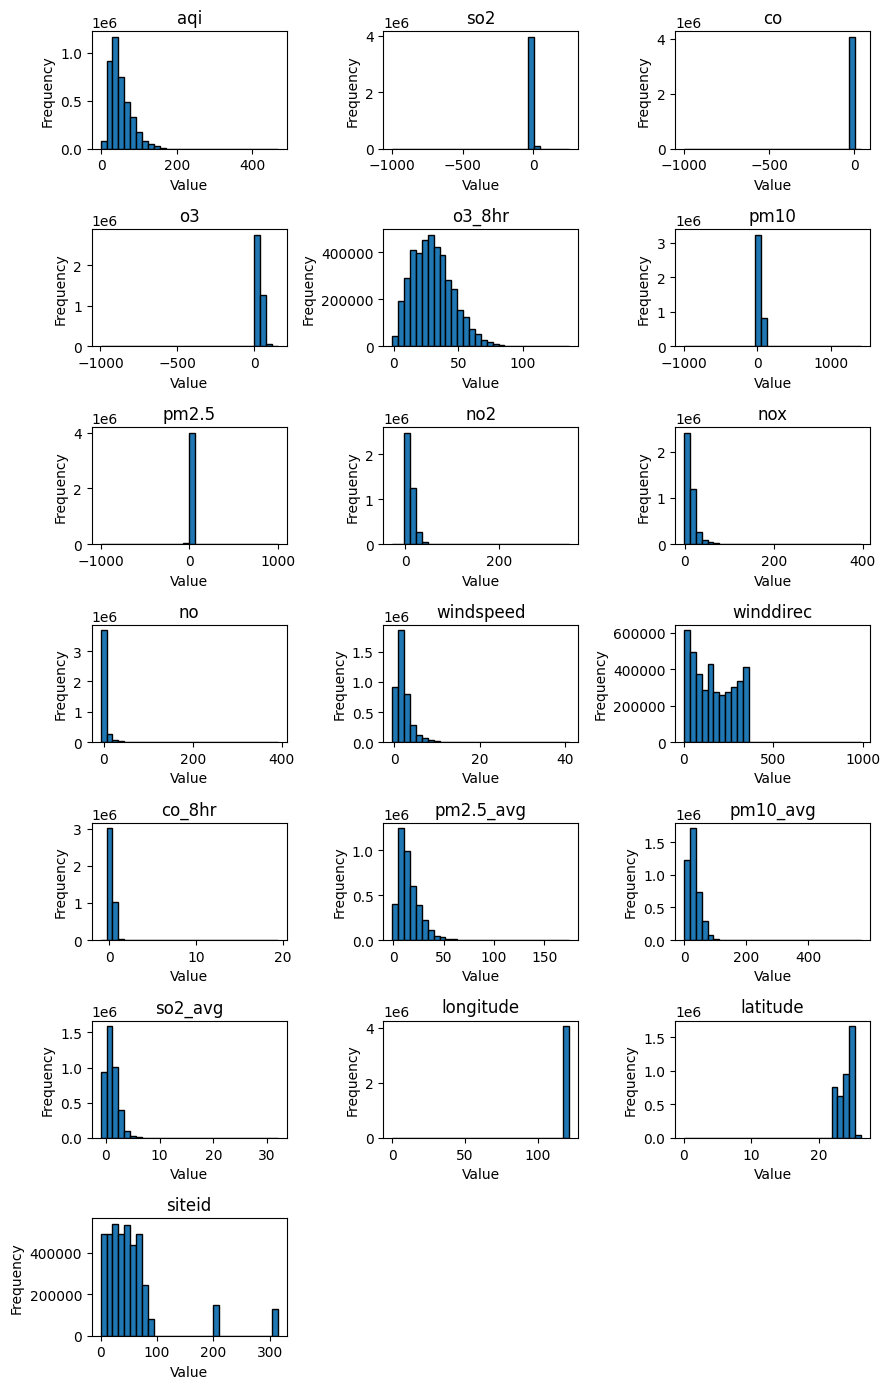

In [ ]:
# Pilih hanya kolom numerik
numeric_cols = df.select_dtypes(include=['float64', 'int64']).columns

#jumlah kolom grid
n_cols = 3
n_rows = (len(numeric_cols) + n_cols - 1) // n_cols

# Buat figure
plt.figure(figsize=(n_cols * 3, n_rows * 2))

# Loop untuk setiap kolom
for i, col in enumerate(numeric_cols, 1):
    plt.subplot(n_rows, n_cols, i)
    plt.hist(df[col].dropna(), bins=30, edgecolor='black')
    plt.title(col)
    plt.xlabel('Value')
    plt.ylabel('Frequency')
    plt.tight_layout()

plt.show()

lakukan transformasi log untuk kolom yang skeewness right (mayoritas kolom spt itu)

In [ ]:
import numpy as np

# daftar kolom yang mau di-log transform
right_skewed_cols = [
    'aqi', 'o3_8hr', 'nox', 'no2', 'no',
    'windspeed', 'pm2.5_avg', 'pm10_avg', 'so2_avg'
]

LOG_THRESHOLD_MAX = 10
LOG_THRESHOLD_MEAN = 2

for col in right_skewed_cols:
    if col not in df.columns:
        print(f"⚠️ Kolom '{col}' tidak ditemukan di DataFrame, skip.")
        continue

    # isi nilai kosong dulu biar gak NaN setelah log
    df[col] = df[col].fillna(0)

    # buang nilai negatif (ganti jadi 0 biar aman di log1p)
    df[col] = df[col].clip(lower=0)

    # ambil statistik dasar
    max_val = df[col].max()
    mean_val = df[col].mean()

    # deteksi apakah sudah di-log sebelumnya
    if max_val < LOG_THRESHOLD_MAX and mean_val < LOG_THRESHOLD_MEAN:
        print(f"⏭️  Kolom '{col}' kemungkinan SUDAH di-log sebelumnya — dilewati.")
        continue

    # lakukan log transform aman
    df[col] = np.log1p(df[col])

    # pastikan gak ada inf/NaN setelah log
    df[col].replace([np.inf, -np.inf], np.nan, inplace=True)
    df[col].fillna(df[col].median(), inplace=True)

    print(f"✅ Log-transform aman diterapkan ke kolom: '{col}' (max={max_val:.2f}, mean={mean_val:.2f})")


lihat histogram pasca di normalisasi

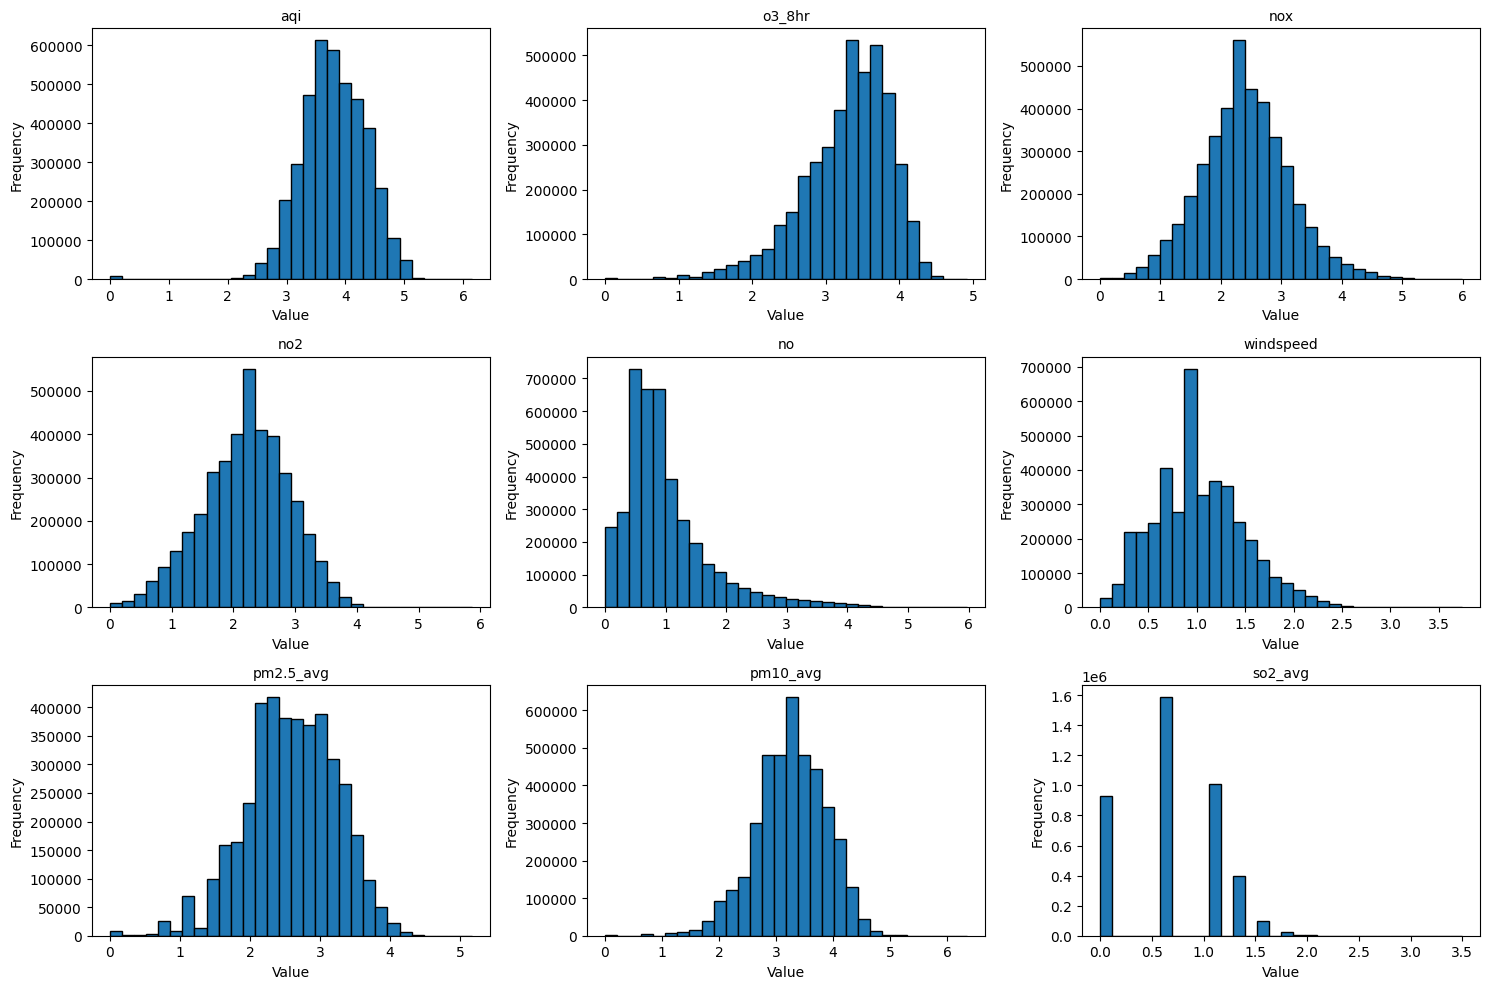

In [ ]:
right_skewed_cols = [
    'aqi', 'o3_8hr', 'nox', 'no2', 'no',
    'windspeed', 'pm2.5_avg', 'pm10_avg', 'so2_avg'
]

# buat grid histogram
n_cols = 3  # jumlah kolom plot per baris
n_rows = int(np.ceil(len(right_skewed_cols) / n_cols))

plt.figure(figsize=(15, 10))
for i, col in enumerate(right_skewed_cols, 1):
    if col in df.columns:
        plt.subplot(n_rows, n_cols, i)
        plt.hist(df[col].dropna(), bins=30, edgecolor='black')
        plt.title(col, fontsize=10)
        plt.xlabel("Value")
        plt.ylabel("Frequency")
    else:
        print(f"⚠️ Kolom '{col}' tidak ditemukan di DataFrame — skip.")

plt.tight_layout()
plt.show()

In [ ]:
#lakukan pengarsipan
df_transform = df.copy()

### cek korelasi

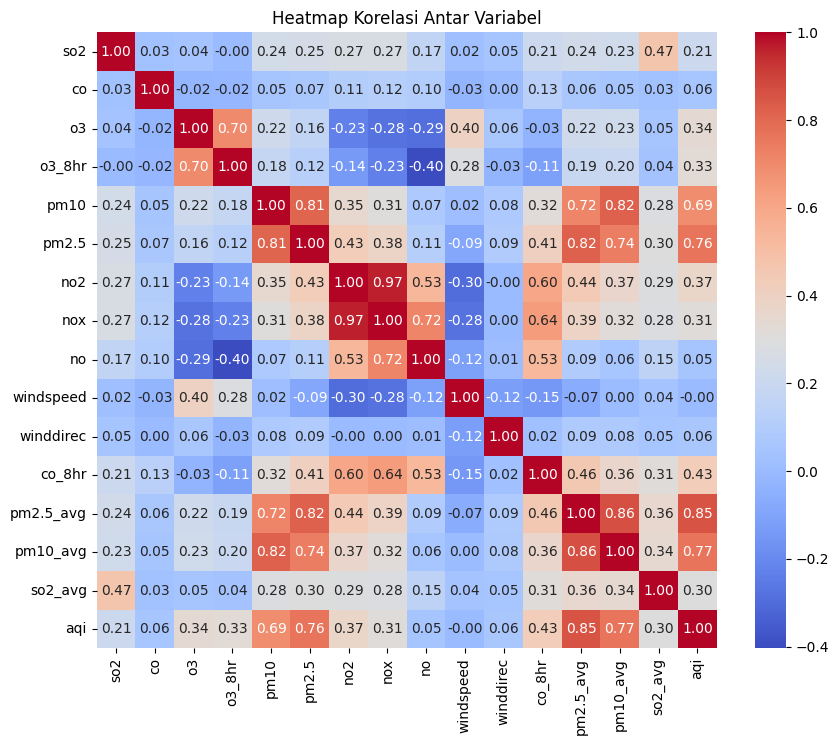

In [ ]:
corr_matrix = df[["so2","co","o3","o3_8hr","pm10","pm2.5","no2","nox","no",
        "windspeed","winddirec","co_8hr","pm2.5_avg","pm10_avg","so2_avg", "aqi"]].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

dari Map Korelasi diatas, yang akan digunakan dalam membuat model adalah co, so2_avg, windspeed, o3 dan pm2.5_avg

### Cek Multikolinieritas

In [ ]:
cols_to_check = ["co", "so2_avg", "windspeed", "o3", "pm2.5_avg"]
X = df[cols_to_check].copy()
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]

In [ ]:
print(vif_data.sort_values(by="VIF", ascending=False))

     Feature       VIF
4  pm2.5_avg  7.999744
2  windspeed  5.611341
3         o3  4.999679
1    so2_avg  3.876987
0         co  1.054777


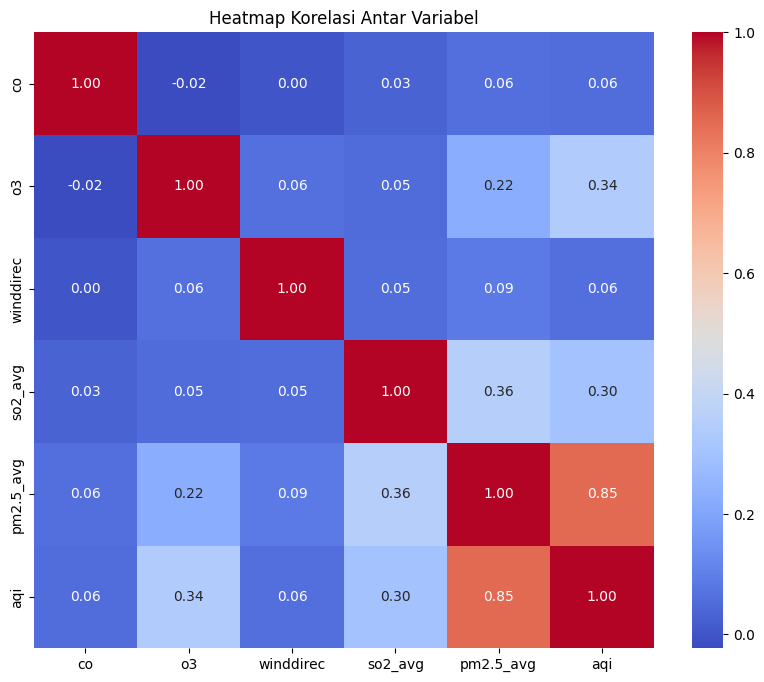

In [ ]:
#buat map korelasi hanya untuk kolom yang akan kita gunakan dalam model
corr_matrix = df[["co","o3","winddirec","so2_avg", "pm2.5_avg", "aqi"]].corr()

import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(10,8))
sns.heatmap(corr_matrix, annot=True, fmt=".2f", cmap='coolwarm')
plt.title("Heatmap Korelasi Antar Variabel")
plt.show()

## Membuat Model

### definisikan target dan fitur

### buat model yang 75% - 25% (ga pakai split per tahun)

In [14]:
from sklearn.model_selection import train_test_split
import statsmodels.api as sm

In [15]:
#tentukan x dan y
X = df[["co", "o3", "winddirec", "so2_avg", "pm2.5_avg"]]
Y = df["aqi"]

In [16]:
#kita split datanya
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

In [17]:
# Tambahkan konstanta untuk OLS
X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

In [18]:
#print modelnya
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    aqi   R-squared:                       0.751
Model:                            OLS   Adj. R-squared:                  0.751
Method:                 Least Squares   F-statistic:                 1.842e+06
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:07:01   Log-Likelihood:            -3.6529e+05
No. Observations:             3047214   AIC:                         7.306e+05
Df Residuals:                 3047208   BIC:                         7.307e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9141      0.001   2861.844      0.0

### buat model berdasarkan split tahun data training : 2020- 2022, dan data testing tahun 2023

In [3]:
df = pd.read_csv("data_sampemodel.csv")

karena ini merupakan data timeseries, maka akan kita cek terlebih dahulu tahunnya

In [4]:
#convert data ke datetime
df["date"] = pd.to_datetime(df["date"], errors="coerce")
df['date'].dtype

dtype('<M8[ns]')

In [5]:
#lihat range data
df["date"].min(), df["date"].max()

(Timestamp('2019-07-15 12:00:00'), Timestamp('2024-08-31 23:00:00'))

karena range data nya dari 15 juli 2019 - 31 agustus 2024, maka untuk split data train adalah tahun 2020-2022 dan data training tahun 2023

In [19]:
# split data nya
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42
)

In [20]:
# kita buat kolom khusus untuk tahun
df["year"] = df["date"].dt.year

In [21]:
train_df = df[(df["year"] >= 2020) & (df["year"] <= 2022)]
test_df  = df[df["year"] == 2023]

In [22]:
X_train = train_df[["co", "so2_avg", "windspeed", "o3", "pm2.5_avg"]]
y_train = train_df["aqi"]

X_test = test_df[["co", "so2_avg", "windspeed", "o3", "pm2.5_avg"]]
y_test = test_df["aqi"]

In [23]:
import statsmodels.api as sm

X_train = sm.add_constant(X_train)
X_test  = sm.add_constant(X_test)

### print modelnya

In [24]:
# model OLS (Ordinary Least Squares)
model = sm.OLS(y_train, X_train).fit()
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                    aqi   R-squared:                       0.764
Model:                            OLS   Adj. R-squared:                  0.764
Method:                 Least Squares   F-statistic:                 1.631e+06
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        07:08:42   Log-Likelihood:            -2.4300e+05
No. Observations:             2512865   AIC:                         4.860e+05
Df Residuals:                 2512859   BIC:                         4.861e+05
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.9120      0.001   2387.265      0.0

prediksi pakai data test (data tahun 2023)

In [25]:
y_pred = model.predict(X_test)

In [26]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test, y_pred)
rmse = mse**0.5
r2 = r2_score(y_test, y_pred)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

MSE: 0.10943085179564399
RMSE: 0.33080334308414117
R2: 0.6538711292167774


## Uji Asumsi Klasik

### Uji Homoskedastisitas

In [ ]:
#uji homoskedastisitas
from statsmodels.stats.diagnostic import het_breuschpagan

# model = sm.OLS(y, X).fit()
# Ambil residual dan variabel independen
residuals = model.resid
exog = model.model.exog

# Lakukan uji Breusch-Pagan
bp_test = het_breuschpagan(residuals, exog)

# Simpan hasilnya
labels = ['Lagrange multiplier statistic', 'p-value',
          'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': np.float64(28500.23275175487), 'p-value': np.float64(0.0), 'f-value': np.float64(5753.850410413392), 'f p-value': np.float64(0.0)}


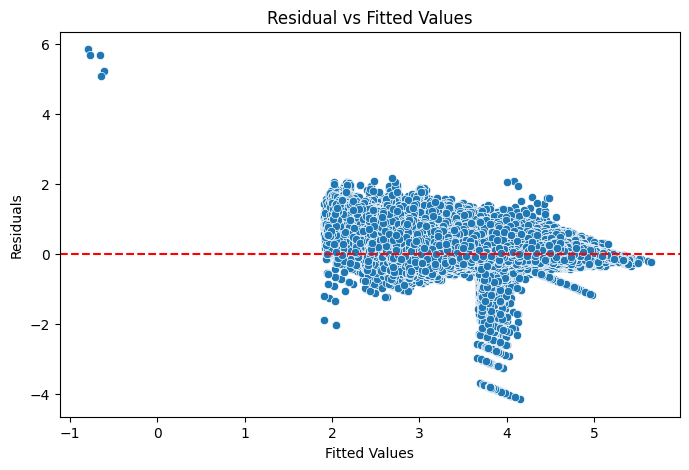

In [ ]:
#visualisasi homoskedastisitas
#sekalian uji linearitas
import matplotlib.pyplot as plt
import seaborn as sns

# Hitung residual dan prediksi
residuals = model.resid
fitted = model.fittedvalues

plt.figure(figsize=(8,5))
sns.scatterplot(x=fitted, y=residuals)
plt.axhline(0, color='red', linestyle='--')
plt.title('Residual vs Fitted Values')
plt.xlabel('Fitted Values')
plt.ylabel('Residuals')
plt.show()

#heteroskedastisitas ringan
#uji linearitas masih cukup terpenuhi

### Uji Multikolinieritas

In [ ]:
#uji multikolinearitas dari data yang dipake di model
from statsmodels.stats.outliers_influence import variance_inflation_factor
import pandas as pd

# Hitung VIF
vif_data = pd.DataFrame()
vif_data["Feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

#udah bagus VIF nya

     Feature       VIF
0         co  1.054777
1    so2_avg  3.876987
2  windspeed  5.611341
3         o3  4.999679
4  pm2.5_avg  7.999744


### Uji Normalitas
disini kita menggunakan test Jarque Bera Test karena data yang digunakan ialah data Time Series dan Jarque Bera Test lebih cocok untuk data Time series

In [ ]:
# statistik jarque bera test
from statsmodels.stats.stattools import jarque_bera
residual = model.resid
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residual)

print("\n=== UJI NORMALITAS (JARQUE-BERA TEST) ===")
print(f"Jarque-Bera Statistic : {jb_stat:.4f}")
print(f"P-Value               : {jb_pvalue:.4f}")
print(f"Skewness              : {skew:.4f}")
print(f"Kurtosis              : {kurtosis:.4f}")

# Interpretasi otomatis
if jb_pvalue > 0.05:
    print("✅ Residual berdistribusi normal (p > 0.05)")
else:
    print("❌ Residual tidak normal (p < 0.05)")

In [ ]:
#visual
import seaborn as sns
import matplotlib.pyplot as plt
import scipy.stats as stats

# Histogram residual + KDE
sns.histplot(residual, kde=True)
plt.title("Distribusi Residual")
plt.show()

# Q-Q plot (normal probability plot)
stats.probplot(residual, dist="norm", plot=plt)
plt.title("Q-Q Plot Residual")
plt.show()


ada sedikit keanehan pada distribusi residualnya, disini nilai nya berkumpul pada rentang -2 hingga 2, salah satu penyebabnya ialah range data yang berbeda jauh

In [ ]:
# Lihat range (max - min) dan standar deviasi
X_train.describe().T[["min", "max", "mean", "std"]]

In [ ]:
# disini ada keanehan yaitu data min untuk co dan o3 sebesar -999.0, oleh karena itu kita ubah -999.0 menjadi NAN. dan diubah menjadi median

import numpy as np

cols_to_fix = ["co", "o3"]  # ganti sesuai kolom yang bermasalah

# Ganti -999 jadi NaN di semua kolom
X_train[cols_to_fix] = X_train[cols_to_fix].replace(-999, np.nan)
X_test[cols_to_fix] = X_test[cols_to_fix].replace(-999, np.nan)

# Isi NaN dengan median (pakai median dari TRAIN)
for col in cols_to_fix:
    median_val = X_train[col].median()
    X_train[col].fillna(median_val, inplace=True)
    X_test[col].fillna(median_val, inplace=True)


In [ ]:
#kita test lagi dengan jerque bera test
model = sm.OLS(y_train, X_train).fit()
residual = model.resid
jb_stat, jb_pvalue, skew, kurtosis = jarque_bera(residual)

print("\n=== UJI NORMALITAS (JARQUE-BERA TEST) ===")
print(f"Jarque-Bera Statistic : {jb_stat:.4f}")
print(f"P-Value               : {jb_pvalue:.4f}")
print(f"Skewness              : {skew:.4f}")
print(f"Kurtosis              : {kurtosis:.4f}")

# Interpretasi otomatis
if jb_pvalue > 0.05:
    print("Residual berdistribusi normal (p > 0.05)")
else:
    print("Residual tidak normal (p < 0.05)")

PERBANDINGAN

Perbandingan jumlah variabel (model dengan variabel lengkap)

In [8]:
#perbandingan model dengan variabel lengkap
import pandas as pd
import statsmodels.api as sm

# 1. Buat kolom tahun dari date
df["year"] = df["date"].dt.year

# 2. Split train-test berdasarkan tahun
train_df_v = df[(df["year"] >= 2020) & (df["year"] <= 2022)]
test_df_v  = df[df["year"] == 2023]

# 3. Daftar kolom yang TIDAK boleh masuk sebagai predictor
exclude_cols = [
    "date", "sitename", "county", "aqi", "pollutant", "status",
    "unit", "longitude", "latitude", "siteid", "year"
]

# 4. Pilih semua kolom numerik kecuali yang dikecualikan
features = [
    col for col in train_df_v.select_dtypes(include=["float64", "int64"]).columns
    if col not in exclude_cols
]

print("Fitur yang dipakai sebagai X:")
print(features)

# 5. Buat X dan y
X_train_v = train_df_v[features]
y_train_v = train_df_v["aqi"]

X_test_v  = test_df_v[features]
y_test_v  = test_df_v["aqi"]

# 6. Tambahkan konstanta
X_train_v = sm.add_constant(X_train_v)
X_test_v  = sm.add_constant(X_test_v)


Fitur yang dipakai sebagai X:
['so2', 'co', 'o3', 'o3_8hr', 'pm10', 'pm2.5', 'no2', 'nox', 'no', 'windspeed', 'winddirec', 'co_8hr', 'pm2.5_avg', 'pm10_avg', 'so2_avg']


In [10]:
# model OLS (Ordinary Least Squares)
model_v = sm.OLS(y_train_v, X_train_v).fit()
print(model_v.summary())

                            OLS Regression Results                            
Dep. Variable:                    aqi   R-squared:                       0.795
Model:                            OLS   Adj. R-squared:                  0.795
Method:                 Least Squares   F-statistic:                 6.514e+05
Date:                Fri, 14 Nov 2025   Prob (F-statistic):               0.00
Time:                        06:55:18   Log-Likelihood:                -65538.
No. Observations:             2512865   AIC:                         1.311e+05
Df Residuals:                 2512849   BIC:                         1.313e+05
Df Model:                          15                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          1.8039      0.002   1004.684      0.0

In [11]:
y_pred_v = model_v.predict(X_test_v)

In [12]:
from sklearn.metrics import mean_squared_error, r2_score

mse = mean_squared_error(y_test_v, y_pred_v)
rmse = mse**0.5
r2 = r2_score(y_test_v, y_pred_v)

print("MSE:", mse)
print("RMSE:", rmse)
print("R2:", r2)

MSE: 0.09708880298861439
RMSE: 0.3115907620399141
R2: 0.6929089265712765


**PERBANDINGAN**

R-Squared: Model lengkap menjelaskan persentase variasi yang lebih besar pada variabel dependen (aqi)


F-statistic: kedua model secara keseluruhan sangat signifikan (Prob (F-statistic) = 0.00). Nilai F yang lebih besar pada Model dengan 5 variabel (meskipun memiliki $R^2$ lebih kecil) menunjukkan bahwa variabelnya secara kolektif menjelaskan variasi yang jauh lebih besar relatif terhadap jumlah variabelnya yang lebih kecil.


Condition Number: Kekhawatiran Utama. Angka di atas 30 menunjukkan multikolinearitas yang kuat. Model lengkap memiliki 4110, menunjukkan masalah multikolinearitas yang sangat parah, yang dapat membuat koefisien menjadi tidak stabil dan sulit diinterpretasikan. Model dengan 5 variabel juga memiliki Cond. No. yang tinggi (179) tetapi jauh lebih rendah daripada Model 1, mengindikasikan bahwa pengurangan variabel telah secara signifikan mengurangi tingkat multikolinearitas, meskipun masih ada.


**KESIMPULAN**
1. Daya Penjelas (Fit): Model lengkap lebih unggul dalam hal $R^2$ dan Adjusted $R^2$ (0.795 vs 0.764) dan memiliki nilai AIC/BIC yang jauh lebih rendah, menunjukkan bahwa model tersebut secara statistik merupakan model yang lebih baik untuk menjelaskan variasi variabel dependen ($aqi$).
2. Masalah Kualitas Model (Multikolinearitas): Model lengkap mengalami masalah yang jauh lebih parah dengan multikolinearitas (Cond. No. $4110$) dibandingkan Model dengan 5 variabel (Cond. No. 179). Hal ini ditunjukkan oleh koefisien $co$ yang berubah tanda secara drastis antara kedua model, yang merupakan tanda klasik dari ketidakstabilan koefisien akibat multikolinearitas yang tinggi.
3. Keterbatasan Umum: Kedua model menunjukkan bukti kuat adanya autokorelasi (Durbin-Watson < 2) dan residual yang tidak berdistribusi normal (Prob(Omnibus) = 0.000).



# STOPPPP

In [ ]:
import statsmodels.api as sm

# Contoh variabel independen dan dependen
X = df[['so2_avg', 'co', 'o3', 'windspeed', 'winddirec']]
y = df['aqi']

# Tambahkan intercept
X = sm.add_constant(X)

# Buat objek OLS
model = sm.OLS(y, X)

# Fungsi untuk cek apakah model sudah fit
def check_fit(model_obj):
    try:
        # Coba akses residual
        _ = model_obj.resid
        print("Model sudah fit")
    except AttributeError:
        print("Model BELUM fit, panggil .fit() dulu")

# Cek sebelum fit
check_fit(model)  # Output: Model BELUM fit

# Fit model
model_fitted = model.fit()

# Cek setelah fit
check_fit(model_fitted)  # Output: Model sudah fit

Model BELUM fit, panggil .fit() dulu
Model sudah fit


In [ ]:
print(model_fitted.summary())

In [ ]:
residuals = model_fitted.resid

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

vif_data = pd.DataFrame()
vif_data["feature"] = X.columns
vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
print(vif_data)

     feature        VIF
0      const  10.772989
1    so2_avg   1.052044
2         co   1.093952
3         o3   1.174253
4  windspeed   1.208649
5  winddirec   1.041614


In [ ]:
from statsmodels.stats.diagnostic import het_breuschpagan

# misal model adalah hasil dari OLS
# model = sm.OLS(y, X).fit()

# Ambil residual dan variabel independen
residuals = model.resid
exog = model.model.exog

# Lakukan uji Breusch-Pagan
bp_test = het_breuschpagan(residuals, exog)

# Simpan hasilnya
labels = ['Lagrange multiplier statistic', 'p-value',
          'f-value', 'f p-value']
print(dict(zip(labels, bp_test)))


{'Lagrange multiplier statistic': np.float64(72975.45126191761), 'p-value': np.float64(0.0), 'f-value': np.float64(5154.574160136841), 'f p-value': np.float64(0.0)}


p-value = 0.0 → sangat kecil, jauh di bawah 0.05

Artinya → tolak H0 → residual tidak konstan

Dengan kata lain, model mengalami heteroskedastisitas

In [ ]:
residuals = model_fitted.resid
exog = model_fitted.model.exog

bp_test = het_breuschpagan(residuals, exog)
labels = ['Lagrange multiplier statistic', 'p-value', 'f-value', 'f p-value']
print("\n=== Breusch-Pagan Test ===")
print(dict(zip(labels, bp_test)))


=== Breusch-Pagan Test ===
{'Lagrange multiplier statistic': np.float64(144563.3779297783), 'p-value': np.float64(0.0), 'f-value': np.float64(32545.587766433626), 'f p-value': np.float64(0.0)}


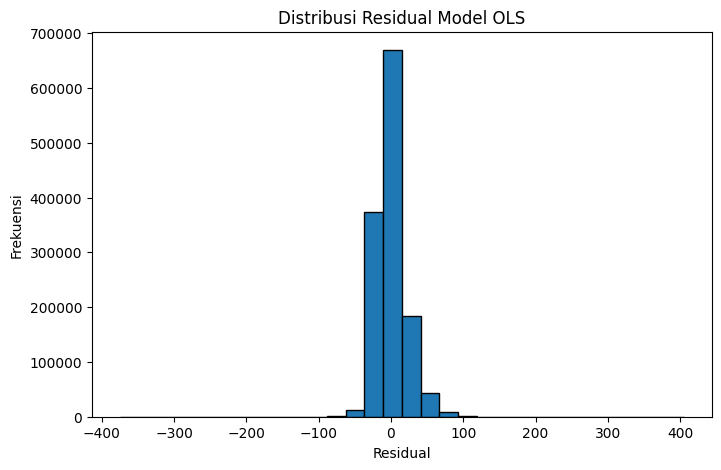

In [ ]:
plt.figure(figsize=(8,5))
plt.hist(residuals[~np.isnan(residuals)], bins=30, edgecolor='k')
plt.title("Distribusi Residual Model OLS")
plt.xlabel("Residual")
plt.ylabel("Frekuensi")
plt.show()

TADI AKU BENERIN SAMPE SINI GESS --YUKE

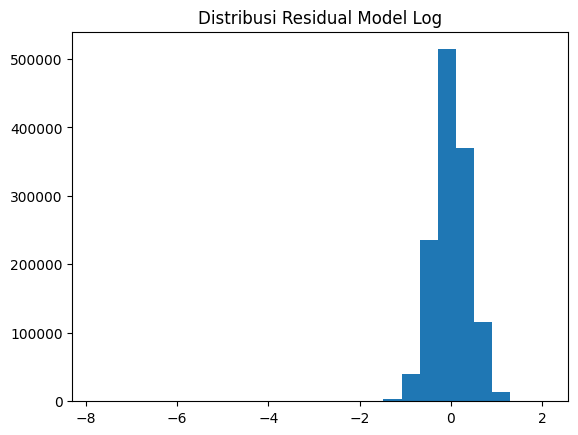

In [ ]:
df = df[df['aqi'] > 0]  # Hanya ambil nilai positif
df = df.dropna(subset=['aqi', 'so2_avg', 'co', 'o3', 'windspeed', 'winddirec'])

y = df['aqi']
X = df[['so2_avg', 'co', 'o3', 'windspeed', 'winddirec']]

# Karena sudah difilter, aman pakai log1p (lebih stabil)
y_log = np.log1p(y)

model_transformed = sm.OLS(y_log, sm.add_constant(X)).fit()

# Plot distribusi residual
import matplotlib.pyplot as plt
plt.hist(model_transformed.resid[~np.isnan(model_transformed.resid)], bins=25)
plt.title("Distribusi Residual Model Log")
plt.show()


In [ ]:
print(len(model_transformed.resid.dropna()))


4061398


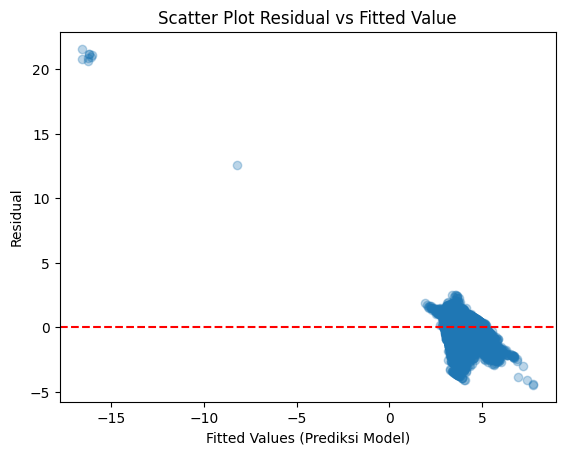

In [ ]:
import matplotlib.pyplot as plt

# Residual dan fitted value dari model
residuals = model_transformed.resid
fitted = model_transformed.fittedvalues

# Plot scatter residual vs fitted value
plt.scatter(fitted, residuals, alpha=0.3)
plt.axhline(0, color='r', linestyle='--')
plt.xlabel('Fitted Values (Prediksi Model)')
plt.ylabel('Residual')
plt.title('Scatter Plot Residual vs Fitted Value')
plt.show()


In [ ]:
from scipy.stats import shapiro
residuals = model_transformed.resid.dropna()
stat, p = shapiro(residuals.sample(5000))  # Gunakan sampel 5000 karena big data
print('Shapiro-Wilk Test: stat=%.3f, p-value=%.3f' % (stat, p))


Shapiro-Wilk Test: stat=0.998, p-value=0.000
